# Model Development and Training


### Predictive Modeling

* Target column: Let’s use fare_amount as default
* Drop irrelevant or non-numeric columns (e.g., trip_id, datetime, pickup_location, etc.)
* Split features (X) and target (y)
* Feature Scaling: Use MinMaxScaler
* Train a model: Random Forest








In [43]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load your dataset
df = pd.read_csv(r"D:\Menternship Project\final_merged_dataset_cleaned.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

# Split into train/val (80/20 split)
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
val_df = df.iloc[split_index:]

# Columns to drop
drop_cols = ['datetime', 'date', 'trip_id', 'dropoff_datetime', 
             'pickup_location', 'dropoff_location', 
             'trip_status', 'weather_condition', 'traffic_level']

# Prepare features and target
X_train = train_df.drop(columns=drop_cols + ['fare_amount'])
y_train = train_df['fare_amount']
X_val = val_df.drop(columns=drop_cols + ['fare_amount'])
y_val = val_df['fare_amount']

# Optional: Sample a smaller portion to reduce memory usage
X_train_sample = X_train.sample(n=20000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_sample)
X_val_scaled = scaler.transform(X_val)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_sample)

# Predict and evaluate
y_pred = rf.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


MAE: 0.0141, RMSE: 0.0420, R²: 0.8402


* Time Series Forecasting (e.g., vehicle_count) with ARIMA


Test RMSE: 0.60


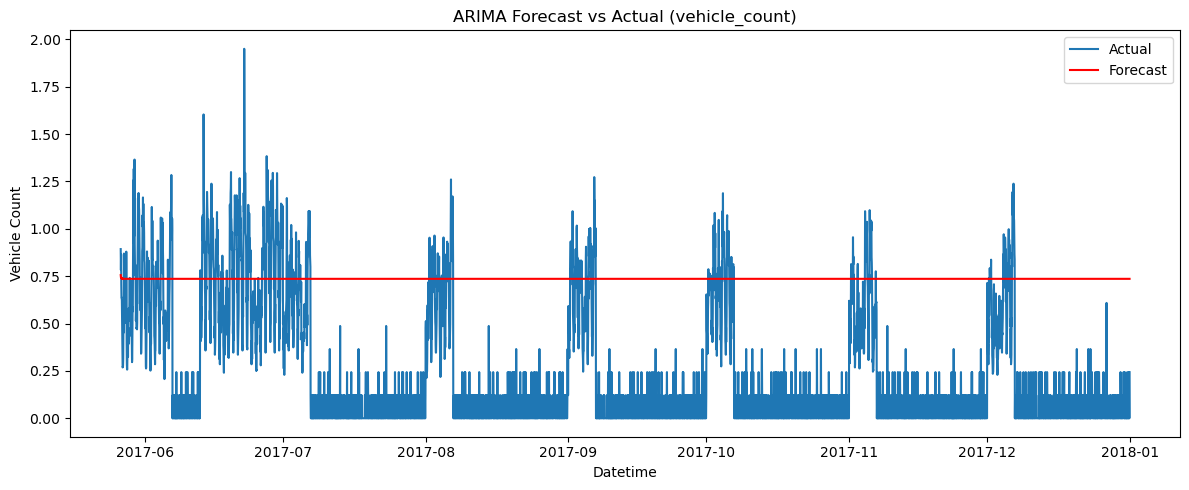

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_csv(r"D:\Menternship Project\final_merged_dataset_cleaned.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

# Aggregate vehicle_count by hour (if not already)
ts_df = df.set_index('datetime').resample('H')['vehicle_count'].sum().fillna(method='ffill')

# Optional: Log transform to stabilize variance
ts_log = np.log1p(ts_df)  # log(1 + x) to avoid log(0)

# Split into train and test
train_size = int(len(ts_log) * 0.8)
train, test = ts_log.iloc[:train_size], ts_log.iloc[train_size:]

# Fit ARIMA (p,d,q) — adjust params if needed
model = ARIMA(train, order=(3,1,2))
model_fit = model.fit()

# Forecast
forecast_log = model_fit.forecast(steps=len(test))
forecast = np.expm1(forecast_log)  # reverse log1p

# Evaluate
actual = np.expm1(test)
rmse = np.sqrt(mean_squared_error(actual, forecast))
print(f"Test RMSE: {rmse:.2f}")

# Plot forecast vs actual
plt.figure(figsize=(12,5))
plt.plot(actual.index, actual, label='Actual')
plt.plot(actual.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual (vehicle_count)')
plt.xlabel('Datetime')
plt.ylabel('Vehicle Count')
plt.legend()
plt.tight_layout()
plt.show()


### Train models and tune hyperparameters


In [72]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.1/150.0 MB 10.7 MB/s eta 0:00:14
   - -------------------------------------- 4.2/150.0 MB 10.1 MB/s eta 0:00:15
   - -------------------------------------- 6.3/150.0 MB 9.9 MB/s eta 0:00:15
   -- ------------------------------------- 8.4/150.0 MB 9.8 MB/s eta 0:00:15
   -- ------------------------------------- 10.5/150.0 MB 9.8 MB/s eta 0:00:15
   --- ------------------------------------ 12.6/150.0 MB 9.7 MB/s eta 0:00:15
   --- ------------------------------------ 14.7/150.0 MB 9.7 MB/s eta 0:00:14
   ---- ----------------------------------- 16.8/150.0 MB 9.6 MB/s eta 0:00:14
   ---- ----------------------------------- 18.6/150.0 MB 9.6 MB/s eta 0:00:14
   ----- ---------------------------------- 20.7/150.0 MB 9.6 MB/s eta 0:00:14
   ------ --------------------------------- 22.5/150.0 MB 9.5 MB/s eta 0:00:14
   ------ --------------------------------- 24.4/150.0 MB 9.5 

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Load dataset
file_path = r"D:\Menternship Project\final_merged_dataset_cleaned.csv"
df = pd.read_csv(file_path)

# Ensure datetime is in proper format
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])
df = df.sort_values('datetime')

X_train = X_train.drop(columns=["datetime"])
X_valid = X_valid.drop(columns=["datetime"])

# Extract time-based features
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month

# Then drop datetime
df = df.drop(columns=["datetime"])


# Drop ID-like columns and define target
df = df.drop(columns=["id", "trip_id", "dropoff_datetime", "date"])
target = 'fare_amount'

# Time-based split
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
valid_df = df.iloc[split_index:]

# Separate features and target
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_valid = valid_df.drop(columns=[target])
y_valid = valid_df[target]

# Categorical columns to encode
cat_cols = ["pickup_location", "dropoff_location", "weather_condition", "traffic_level", "trip_status"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

# Build the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(objective="reg:squarederror", random_state=42))
])

# Hyperparameter grid
param_dist = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__learning_rate": [0.01, 0.05, 0.1],
    "regressor__max_depth": [3, 5, 7],
    "regressor__subsample": [0.6, 0.8, 1.0],
    "regressor__colsample_bytree": [0.6, 0.8, 1.0]
}

# Perform RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

# Evaluate
best_model = search.best_estimator_
y_pred = best_model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

search.best_params_, mae, r2


Fitting 3 folds for each of 10 candidates, totalling 30 fits


({'regressor__subsample': 1.0,
  'regressor__n_estimators': 300,
  'regressor__max_depth': 3,
  'regressor__learning_rate': 0.05,
  'regressor__colsample_bytree': 0.6},
 0.013801011293864988,
 0.8603133878878415)

# Model Evaluation & Cross Validation


#### 1. Select Evaluation Metrics

We use:

MAE (Mean Absolute Error): average absolute difference

RMSE (Root Mean Square Error): penalizes large errors

R² (R-squared): variance explained



In [100]:
# Re-import necessary libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Load the re-uploaded dataset
file_path = r"D:\Menternship Project\final_merged_dataset_cleaned.csv"
df = pd.read_csv(file_path)

# Parse datetime and sort
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])
df = df.sort_values('datetime')

# Extract datetime features and drop the original datetime column
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df = df.drop(columns=["datetime", "id", "trip_id", "dropoff_datetime", "date"])

# Define target and features
target = 'fare_amount'
X = df.drop(columns=[target])
y = df[target]

# Time-based train-validation split
split_index = int(len(df) * 0.8)
X_train, X_valid = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_valid = y.iloc[:split_index], y.iloc[split_index:]

# Categorical columns to be encoded
cat_cols = ["pickup_location", "dropoff_location", "weather_condition", "traffic_level", "trip_status"]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

# Define and train the pipeline model
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(objective="reg:squarederror", random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict on validation data
y_pred = model.predict(X_valid)

# Calculate evaluation metrics
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

mae, rmse, r2


(0.01452170071147222, 0.04226478552556675, 0.8379052703131518)

### 2. Evaluate model performance


#### A. Prediction vs Actual Plot

This shows how close the predictions are to the actual values.


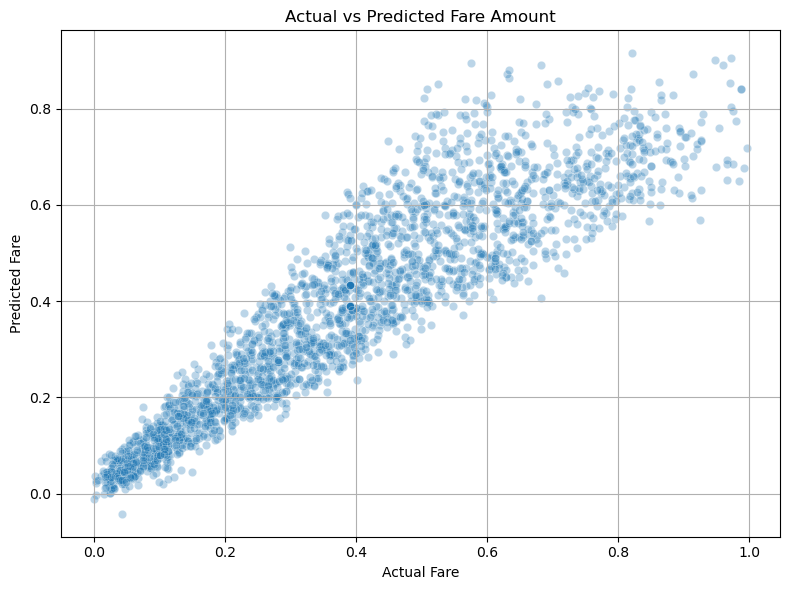

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=y_pred, alpha=0.3)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Fare Amount")
plt.grid(True)
plt.tight_layout()
plt.show()


#### B. Residual Plot

Residuals = Actual - Predicted. This shows if the model tends to over- or under-predict.



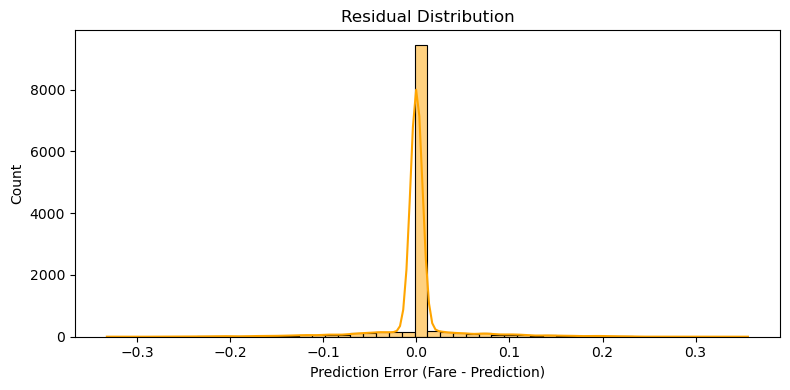

In [109]:
residuals = y_valid - y_pred

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True, color='orange')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Fare - Prediction)")
plt.tight_layout()
plt.show()


### 3. Implement cross-validation


Unlike k-fold cross-validation which randomly splits the data (and breaks time order), TimeSeriesSplit preserves the chronological order — making it suitable for time series or temporally-sensitive data like Uber fares.



In [113]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# Define time-based cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Compute cross-validation scores
mae_scores = -cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

# Display results
print("TimeSeries Cross-Validation Results (5 splits):")
print(f"Mean Absolute Error (MAE): {mae_scores.mean():.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_scores.mean():.4f}")
print(f"R-squared (R²): {r2_scores.mean():.4f}")


TimeSeries Cross-Validation Results (5 splits):
Mean Absolute Error (MAE): 0.0098
Root Mean Squared Error (RMSE): 0.0344
R-squared (R²): 0.8306


### Optional Visualization



You can plot the metric scores across the 5 folds




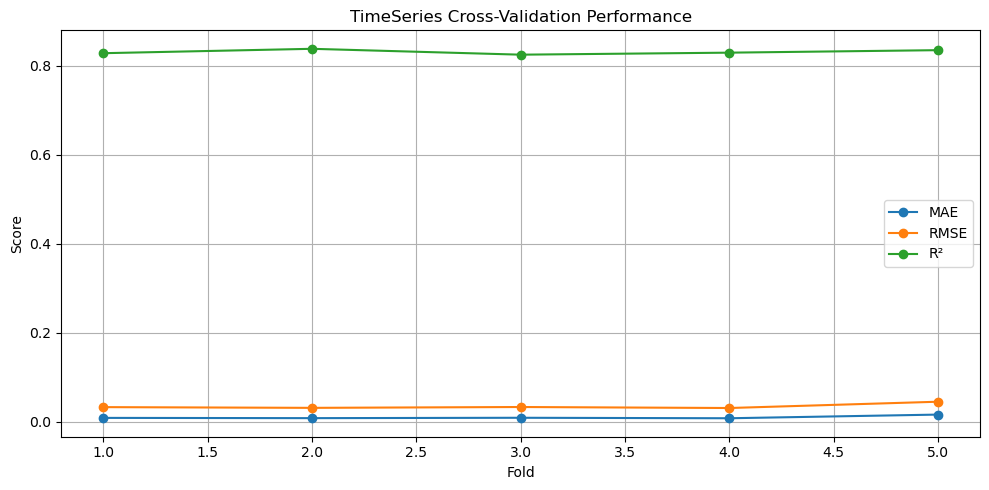

In [117]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores
})

plt.figure(figsize=(10, 5))
plt.plot(results_df['Fold'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Fold'], results_df['RMSE'], marker='o', label='RMSE')
plt.plot(results_df['Fold'], results_df['R2'], marker='o', label='R²')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('TimeSeries Cross-Validation Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Below is a complete Python script that ensures the model validation process reflects real-world conditions by preserving the temporal order of data using:

Chronological train-validation split

TimeSeriesSplit cross-validation

Evaluation with MAE, RMSE, R²



Holdout Validation Results:
MAE  : 0.0145
RMSE : 0.0423
R²   : 0.8379

TimeSeries Cross-Validation (5 folds):
Avg MAE : 0.0098
Avg RMSE: 0.0344
Avg R²  : 0.8306


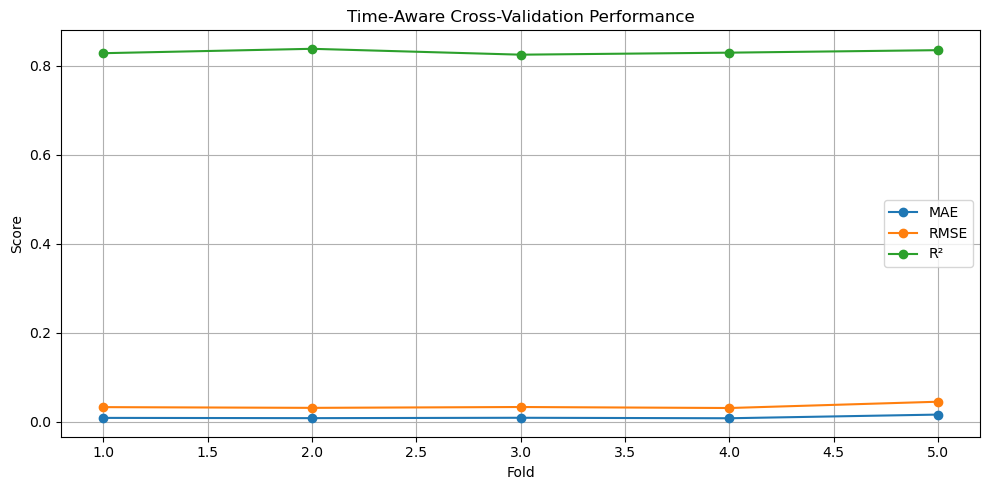

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Step 1: Load and prepare data
df = pd.read_csv(r"D:\Menternship Project\final_merged_dataset_cleaned.csv")

# Step 2: Parse and sort datetime
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])
df = df.sort_values('datetime')

# Step 3: Feature engineering
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df = df.drop(columns=["datetime", "id", "trip_id", "dropoff_datetime", "date"])

# Step 4: Define features and target
target = 'fare_amount'
X = df.drop(columns=[target])
y = df[target]

# Step 5: Train-validation split preserving time
split_index = int(len(df) * 0.8)
X_train, X_valid = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_valid = y.iloc[:split_index], y.iloc[split_index:]

# Step 6: Define preprocessing and model pipeline
cat_cols = ["pickup_location", "dropoff_location", "weather_condition", "traffic_level", "trip_status"]

preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(objective="reg:squarederror", random_state=42))
])

# Step 7: Train and evaluate on validation set
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print("Holdout Validation Results:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# Step 8: TimeSeries Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

mae_scores = -cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

print("\nTimeSeries Cross-Validation (5 folds):")
print(f"Avg MAE : {mae_scores.mean():.4f}")
print(f"Avg RMSE: {rmse_scores.mean():.4f}")
print(f"Avg R²  : {r2_scores.mean():.4f}")

# Step 9: Plot Cross-Validation Results
results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R²': r2_scores
})

plt.figure(figsize=(10, 5))
plt.plot(results_df['Fold'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Fold'], results_df['RMSE'], marker='o', label='RMSE')
plt.plot(results_df['Fold'], results_df['R²'], marker='o', label='R²')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Time-Aware Cross-Validation Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4. Analyze cross-validation results


To analyze your cross-validation results, you want to look at -

The average performance across folds

The variation (standard deviation) between folds

Signs of overfitting or underfitting based on metrics like MAE, RMSE, and R²



#### a. Compile and Summarize the Results


In [9]:
import pandas as pd

results_df = pd.DataFrame({
    'Fold': range(1, len(mae_scores) + 1),
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R²': r2_scores
})

summary = results_df.describe()
print("Cross-Validation Summary:")
print(summary)


Cross-Validation Summary:
           Fold       MAE      RMSE        R²
count  5.000000  5.000000  5.000000  5.000000
mean   3.000000  0.009763  0.034431  0.830576
std    1.581139  0.003473  0.005899  0.005337
min    1.000000  0.007689  0.030690  0.824336
25%    2.000000  0.007926  0.031038  0.827657
50%    3.000000  0.008509  0.032664  0.828876
75%    4.000000  0.008763  0.032925  0.834481
max    5.000000  0.015928  0.044837  0.837527


This will show mean, std, min, max for each metric.

Interpretation:

Low std for MAE/RMSE → consistent performance across time

High std → model may be sensitive to time shifts (i.e., traffic patterns vary widely)

R² near 1 → good fit. R² < 0 or negative → model performs worse than baseline



#### b. Visualize Fold-wise Performance


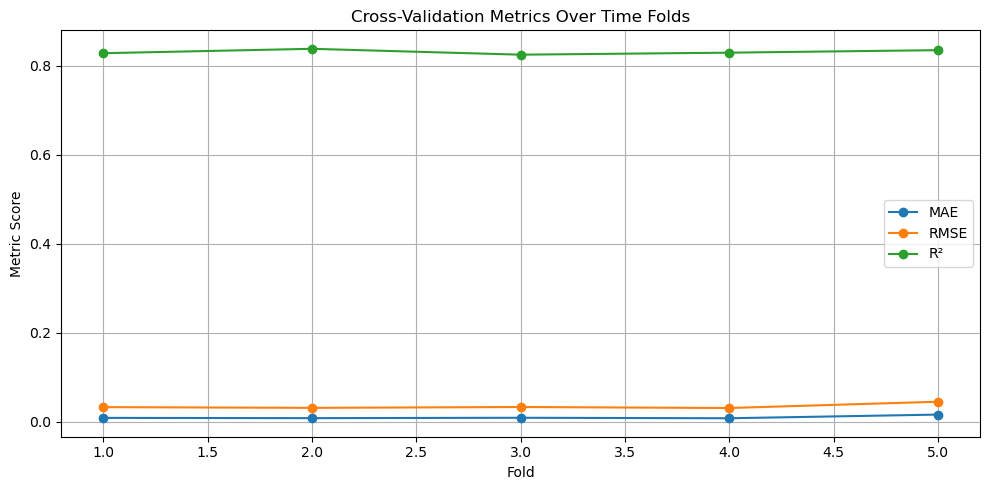

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_df['Fold'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Fold'], results_df['RMSE'], marker='o', label='RMSE')
plt.plot(results_df['Fold'], results_df['R²'], marker='o', label='R²')
plt.xlabel('Fold')
plt.ylabel('Metric Score')
plt.title('Cross-Validation Metrics Over Time Folds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### c. Signs of Overfitting or Underfitting



| Symptom                           | Diagnosis                          | Suggested Fix                           |
| --------------------------------- | ---------------------------------- | --------------------------------------- |
| High variance across folds        | Model not generalizing across time | Use simpler model or add regularization |
| Low R² (near or below 0)          | Underfitting                       | Add features or use more complex model  |
| High training R² but low CV R²    | Overfitting                        | Add regularization, reduce complexity   |
| MAE/RMSE increases in later folds | Concept drift                      | Consider retraining more frequently     |


* Here is the complete code which
* performs time-based cross-validation with XGBoost
* calculates MAE, RMSE, and R² for each fold
* compiles results across folds
* visualizes performance to diagnose overfitting or underfitting.

Fold 1: MAE=0.02, RMSE=0.02, R²=0.89
Fold 2: MAE=0.01, RMSE=0.02, R²=0.92
Fold 3: MAE=0.02, RMSE=0.03, R²=0.94
Fold 4: MAE=0.02, RMSE=0.03, R²=0.96
Fold 5: MAE=0.02, RMSE=0.03, R²=0.96

 Cross-Validation Summary:
Average MAE:  0.02 ± 0.00
Average RMSE: 0.03 ± 0.00
Average R²:   0.93 ± 0.02


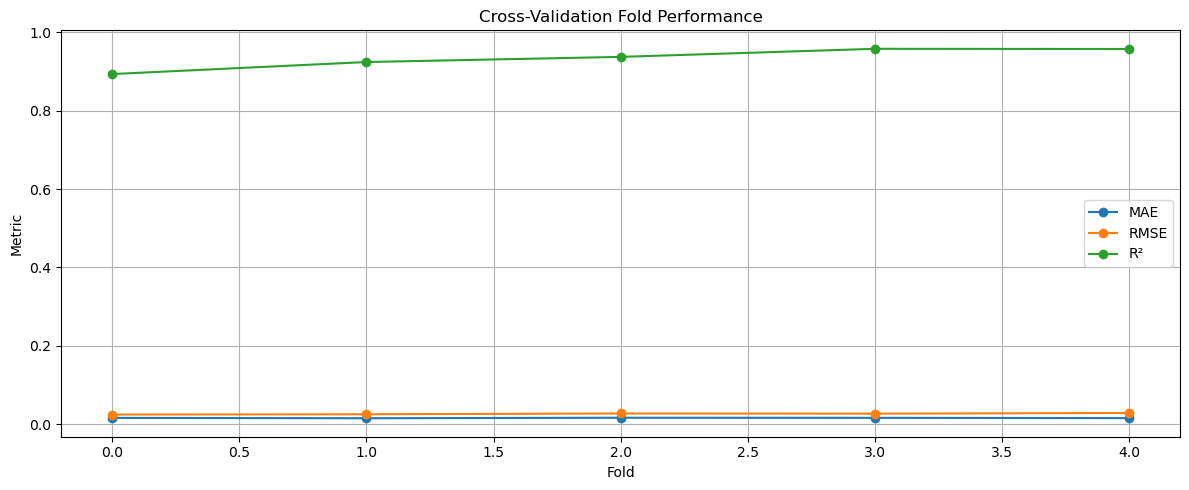

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Load dataset
df = pd.read_csv(r"D:\Menternship Project\final_merged_dataset_cleaned.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")

# Define features and target
features = [
    'hour', 'day_of_week', 'month', 'lag_1h', 'lag_24h', 'lag_168h',
    'is_weekend', 'temp', 'humidity', 'precipitation', 'windspeed',
    'concert', 'holiday', 'sports_event', 'protest',
    'pickup_location', 'dropoff_location', 'trip_status',
    'weather_condition', 'traffic_level'
]
target = 'vehicle_count'

X = df[features].copy()
y = df[target]

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}")

# Summary
print("\n Cross-Validation Summary:")
print(f"Average MAE:  {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"Average R²:   {np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}")

# Plot metrics across folds
plt.figure(figsize=(12, 5))
plt.plot(mae_scores, marker='o', label='MAE')
plt.plot(rmse_scores, marker='o', label='RMSE')
plt.plot(r2_scores, marker='o', label='R²')
plt.title("Cross-Validation Fold Performance")
plt.xlabel("Fold")
plt.ylabel("Metric")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
